In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle

# ML
from cymetric.models.tfhelper import prepare_tf_basis, train_model

# training
from cymetric.models.tfmodels import PhiFSModelToric
from cymetric.models.callbacks import SigmaCallback, TransitionCallback, RicciCallback, VolkCallback
from cymetric.models.metrics import SigmaLoss, TransitionLoss, RicciLoss, VolkLoss
from cymetric.models.measures import sigma_measure, transition_measure_loss, ricci_measure

## Load data

In [2]:
work_dir = "./ToricModel"
tf.get_logger().setLevel('ERROR')
data = np.load(os.path.join(work_dir, 'dataset.npz'))
toric_data = np.load(os.path.join(work_dir, 'toric_data.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(np.load(os.path.join(work_dir, 'basis.pickle'), allow_pickle=True))

## Initialize Loss

In [3]:
scb = SigmaCallback((data['X_val'], data['y_val']))
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
volkck = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, volkck, rcb]

cmetrics = [SigmaLoss(), VolkLoss()]

## Initialize NN params

In [4]:
nfold       = int(BASIS['NFOLD'].numpy().real)
amb         = [int(6)]
n_in        = int(12)
n_out       = int(1)
n_hiddens   = [int(128), int(128), int(128)]
acts        = ['gelu', 'gelu', 'gelu']
n_epochs    = int(30)
batch_sizes = [int(128), int(50000)]
alpha       = [float(1.), float(1.), float(1.), float(1.), float(1.)]

## Initialize NN

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(int(n_in))))
for n_hidden, act in zip(n_hiddens, acts):
    model.add(tf.keras.layers.Dense(n_hidden, activation=act))
model.add(tf.keras.layers.Dense(n_out, use_bias=False))

fs_model = PhiFSModelToric(model, BASIS, alpha=alpha, toric_data=toric_data)

## Train NN

In [6]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Uncomment to silence TF logger
fs_model, training_history = train_model(fs_model, data, epochs=n_epochs, batch_sizes=batch_sizes,
                                         verbose=1, custom_metrics=cmetrics, callbacks=cb_list)


Epoch  1/30


2022-04-10 02:02:36.911178: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 - Sigma measure val:      0.5460
 - Volk val:               19.7683
 - Ricci measure val:      9.8630
352/352 [==============================] - ETA: 0s - sigma_loss: 0.3818 - volk_loss: 0.0000e+00 - Sigma measure val:      0.4385
 - Volk val:               13.1080
 - Ricci measure val:      7.4275
352/352 [==============================] - 24s 58ms/step - sigma_loss: 0.3818 - volk_loss: 0.0000e+00 - sigma_val: 0.4385 - volk_val: 13.1080 - ricci_val: 7.4275
 - Sigma measure val:      0.4385
 - Volk val:               13.1080
 - Ricci measure val:      7.4275


/Users/giorgibutbaia/Desktop/CalabiYau/metric/cymetric/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:2", shape=(None,), dtype=int64), values=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:1", shape=(None, 90, 6), dtype=complex64), dense_shape=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:3", shape=(3,), dtype=int64))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/giorgibutbaia/Desktop/CalabiYau/metric/cymetric/cymetric/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/while_grad/gradients/while/PartitionedCall_grad/PartitionedCall:5", shape=(None,), dtype=int64

1/1 [==============================] - ETA: 0s - sigma_loss: 0.3156 - volk_loss: 6.0000 - Sigma measure val:      0.4391
 - Volk val:               13.3023
 - Ricci measure val:      7.4631
1/1 [==============================] - 18s 18s/step - sigma_loss: 0.3156 - volk_loss: 6.0000 - sigma_val: 0.4391 - volk_val: 13.3023 - ricci_val: 7.4631

Epoch  2/30
 - Sigma measure val:      0.4391
 - Volk val:               13.3023
 - Ricci measure val:      7.4631
351/352 [============================>.] - ETA: 0s - sigma_loss: 0.3083 - volk_loss: 0.0000e+00 - Sigma measure val:      0.4166
 - Volk val:               14.0220
 - Ricci measure val:      7.7954
352/352 [==============================] - 21s 51ms/step - sigma_loss: 0.3083 - volk_loss: 0.0000e+00 - sigma_val: 0.4166 - volk_val: 14.0220 - ricci_val: 7.7954
 - Sigma measure val:      0.4166
 - Volk val:               14.0220
 - Ricci measure val:      7.7954
1/1 [==============================] - ETA: 0s - sigma_loss: 0.2962 - volk_los

## Display results

In [7]:
dets_fs = np.real(tf.linalg.det(fs_model.fubini_study_pb(tf.cast(data['X_train'], tf.float32))).numpy())
dets_cy = np.real(tf.linalg.det(fs_model(tf.cast(data['X_train'], tf.float32))).numpy())
weights, omegas = data['y_train'][:,-2], data['y_train'][:,-1]
vol_k_fs = np.mean(weights * dets_fs / omegas)
vol_k_cy = np.mean(weights * dets_cy / omegas)
print("Vol_K from triple intersection numbers at t1=t2=1:                ", toric_data['vol_j_norm'])
print("Vol_K from MC integration over FS metric in Kahler class t1=t2=1: ", np.round(vol_k_fs, 2))
print("Vol_K from MC integration over CY metric in Kahler class t1=t2=1: ", np.round(vol_k_cy, 2))

Vol_K from triple intersection numbers at t1=t2=1:                 20
Vol_K from MC integration over FS metric in Kahler class t1=t2=1:  20.03
Vol_K from MC integration over CY metric in Kahler class t1=t2=1:  17.27


In [8]:
fs_model.get_kahler_potential(data['X_train'][:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.43858156, 0.39040598, 0.5065061 , 0.48497465, 0.2922448 ,
       0.32530552, 0.47237054, 0.49262947, 0.31962052, 0.1787675 ],
      dtype=float32)>

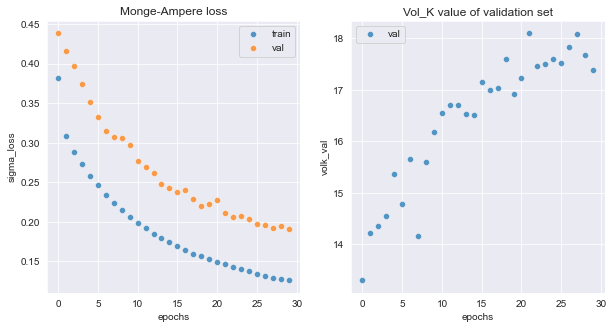

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

hist = training_history
hist['epochs'] = list(range(n_epochs))
hist_data = pd.DataFrame(hist)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5));
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Vol_K value of validation set")
sns.scatterplot(x='epochs', y='volk_val', data=hist_data, alpha=0.75, ax=ax2, label="val");